# Impact of resolution and numeric schemas over trajectories predictions quality

In [1]:
import numpy as np
import xarray as xr
from math import *
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import pyplot as plt

import stagem1.temporal_integration as sti
import stagem1.int_temp_integration as iti
import xsimlab as xs
from scipy.stats import norm
import seaborn as sns

In [2]:
x=iti.SetUp()
y=sti.SetUp()

In [3]:
x.out_ds

<xarray.Dataset>
Dimensions:                 (a: 100, otime: 143, t: 150, time: 144, x: 410)
Coordinates:
  * a                       (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime                   (otime) int64 0 3600 7200 ... 504000 507600 511200
  * t                       (t) float64 -7.2e+03 -3.6e+03 ... 5.292e+05
  * time                    (time) int64 0 3600 7200 ... 507600 511200 514800
  * x                       (x) float64 -1.037e+05 -1.027e+05 ... 3.053e+05
    otime_day               (otime) float64 0.0 0.04167 0.08333 ... 5.875 5.917
    t_day                   (t) float64 -0.08333 -0.04167 0.0 ... 6.083 6.125
    x_km                    (x) float64 -103.7 -102.7 -101.7 ... 304.3 305.3
Data variables: (12/23)
    init__N                 int64 100
    init__maxi              float64 2e+05
    init__mini              int64 0
    position__p             (otime, a) float64 0.0 2.02e+03 ... 2.517e+05
    v_field__advected       int64 1
    v_field__k              float64 6.283e-05
    ...                      ...
    position_km             (otime, a) float64 0.0 2.02 4.04 ... 249.6 251.7
    displacement            (otime, a) float64 0.0 0.0 ... 5.163e+04 5.17e+04
    displacement_km         (otime, a) float64 0.0 0.0 0.0 ... 51.58 51.63 51.7
    velocity_field          (t, x) float64 0.1652 0.1603 ... 0.09121 0.08498
    diff_acc                (otime, a) float64 -3.911e-07 ... 1.404e-05
    CFL                     float64 0.72

# Comparaison accélérations
Pour x un objet SetUp
* `x.analytical_acc()` renvoie le dataset contenant pour toutes les bouées a et à tous les temps otime l'accélération analytique sur la trajectoire, donnée par:

$$ A_a(t)=-U_w[\omega -k[U_m+U_w\cos(\omega t-kx_a(t))]]\sin(\omega t -kx_a(t) ) $$  

$$\text{et } A_a(t)=-U_w[\omega+kU_m-k[U_m+U_w\cos(\omega t+kU_mt-kx_a(t)]]\sin(\omega t + kU_m t -kx_a(t))$$
respectivement dans le cas advecté et dans le cas non advecté
* `x.out_ds.diff_acc` est l'accélération différentiée à partir des vitesses obtenues avec interpolation via la fonction de xarray xarray.differentiate

* $\epsilon_{acc} est la différence de ces deux quantités

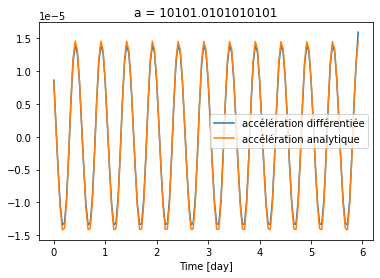

In [4]:
x=iti.SetUp()
x.out_ds.diff_acc.isel(a=5).plot(x='otime_day', label='accélération différentiée')
x.analytical_acc().isel(a=5).plot(x='otime_day', label='accélération analytique')
plt.legend()

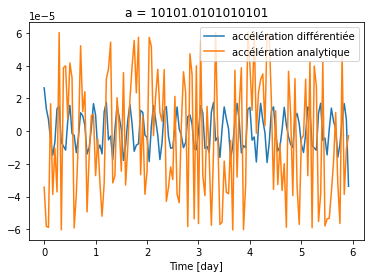

In [5]:
x=iti.SetUp(k=0.01)
x.out_ds.diff_acc.isel(a=5).plot(x='otime_day', label='accélération différentiée')
x.analytical_acc().isel(a=5).plot(x='otime_day', label='accélération analytique')
plt.legend()

In [6]:
def run_acc(K,W,a=5,**args):
    l=len(K)
    fig, axes = plt.subplots(nrows=4, ncols=l, figsize=(14,10), sharex='all', sharey='row')
    y=iti.SetUp(**args)
    
    for i in range(l):
        y.update_parameters(v_field__k=K[i])
        y.analytical_acc().isel(a=a).plot(x='otime_day', label='accélération analytique', ax=axes[0][i], color='darkblue')
        y.out_ds.diff_acc.isel(a=a).plot(x='otime_day', label='accélération différentiée', ax=axes[0][i],color='lightseagreen')
        
        (y.out_ds.diff_acc-y.analytical_acc()).isel(a=5).plot(x='otime_day', ax=axes[1][i], color='salmon')
        axes[0][i].annotate(r'$\lambda$ ='+str(np.round(2*np.pi/K[i]/iti.km,2))+' km', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
        axes[0][i].set_title('')
        axes[1][i].set_title('')

    
    y=iti.SetUp(**args)
    for i in range(l):
        y.update_parameters(v_field__w=W[i])
        y.analytical_acc().isel(a=a).plot(x='otime_day', label='accélération analytique', ax=axes[2][i],color='darkblue')
        y.out_ds.diff_acc.isel(a=a).plot(x='otime_day', label='accélération différentiée', ax=axes[2][i],color='lightseagreen')
        
        (y.out_ds.diff_acc-y.analytical_acc()).isel(a=5).plot(x='otime_day', ax=axes[3][i], color='salmon')
        axes[2][i].annotate(r'T ='+str(np.round(2*np.pi/W[i]/iti.h2s,2))+' h', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
        axes[2][i].set_title('')
        axes[3][i].set_title('')
    
    #ylabels
    axes[0][0].set_ylabel(r'Accélérations $[m.s^{-2}]$', fontsize=12)
    axes[1][0].set_ylabel(r'$ \epsilon_{acc}$ $[m.s^{-2}]$', fontsize=12)
    axes[2][0].set_ylabel(r'Accélérations $[m.s^{-2}]$', fontsize=12)
    axes[3][0].set_ylabel(r'$ \epsilon_{acc}$ $[m.s^{-2}]$', fontsize=12)
    for i in range(l-1):
        axes[0][i+1].set_ylabel('')
        axes[1][i+1].set_ylabel('')
        axes[2][i+1].set_ylabel('')
        axes[3][i+1].set_ylabel('')
    
    ##Only one legend for all    
    lines, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(lines, labels,bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=6, fontsize=15)

    inter_method=y.out_ds.velocity__inter_method.values
    if inter_method=='bilinear':        
        fig.suptitle('Interpolation bilinéaire', fontsize=20)
    else:      
        fig.suptitle('Interpolation de Lagrange', fontsize=20)
    
    plt.tight_layout(rect=[0,0.07,1,1])#left, bottom, right, top (default is 0,0,1,1)
    plt.draw()

## Cas advecté

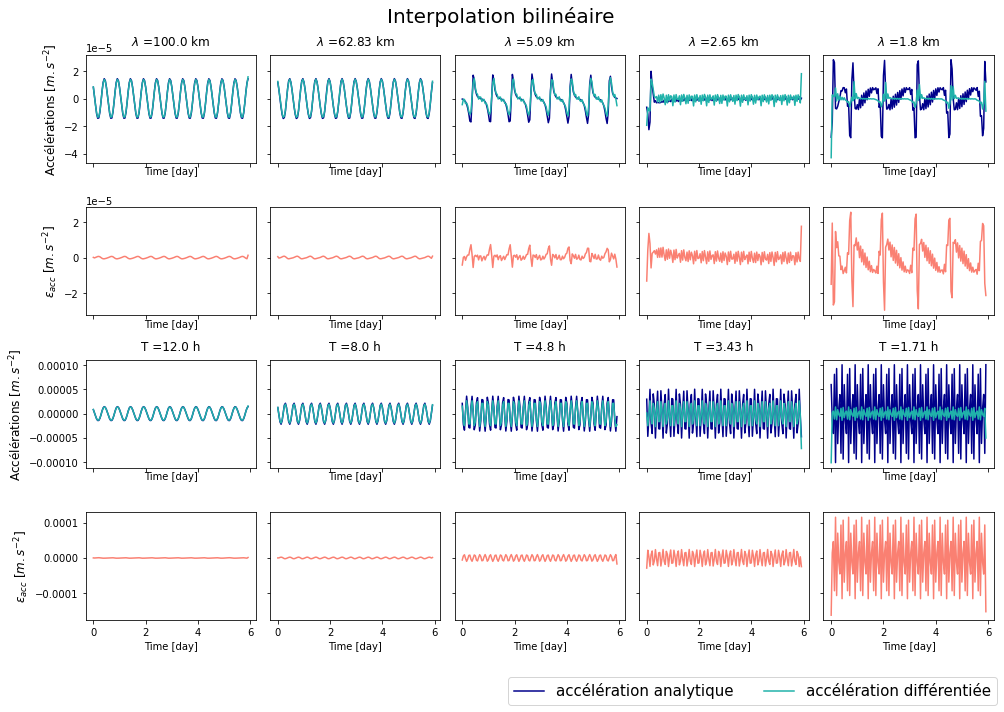

In [13]:
W=[x*sti.w2 for x in [1,1.5,2.5,3.5,7]]
Ka=[iti.k2]+list(np.linspace(0.0001,0.0035,len(W)-1))
K=[iti.k2]+list(np.linspace(0.0001,0.001,len(W)-1))
run_acc(Ka,W)

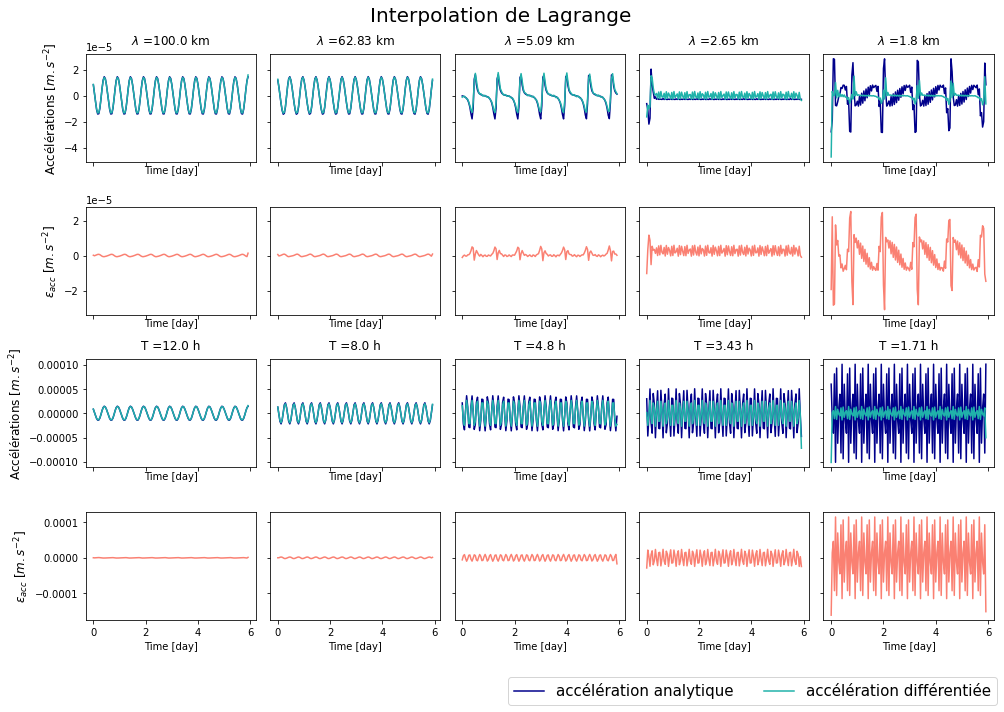

In [14]:
run_acc(Ka,W, inter_method='lagrange')

## Cas non advecté

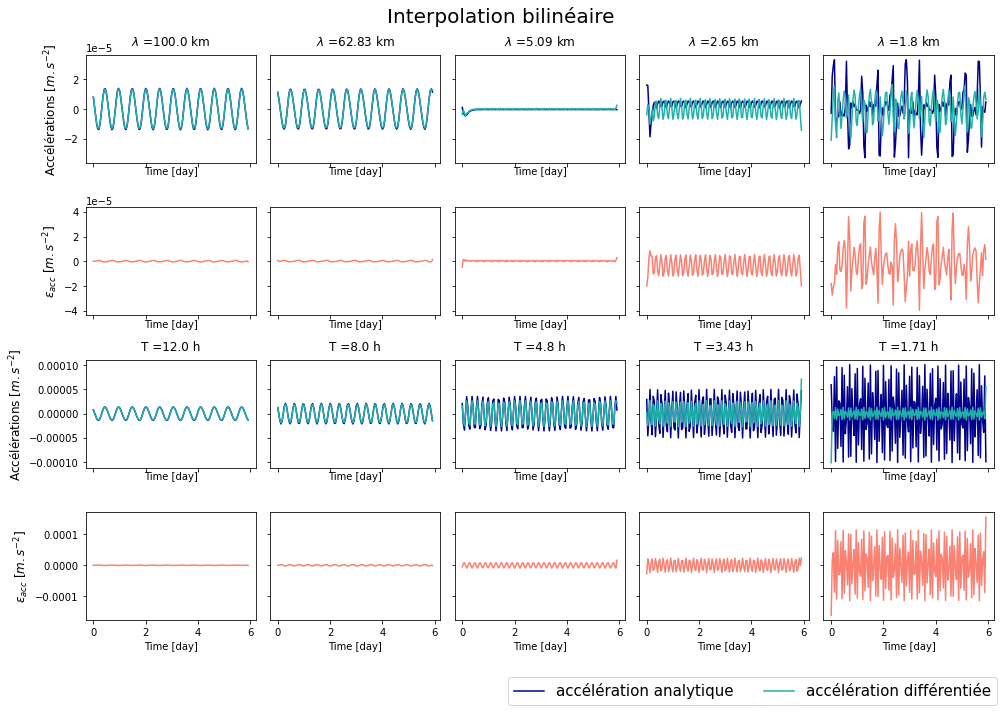

In [15]:
run_acc(Ka,W, advected=0)

# Avec $\delta t$=0.5 dt:

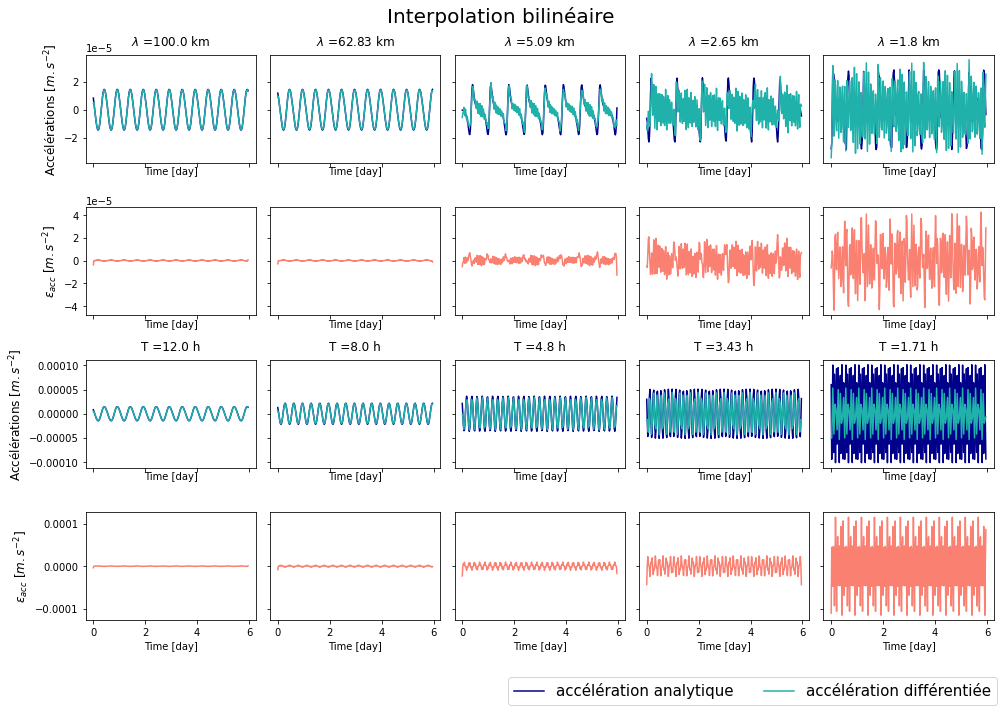

In [24]:
time = np.arange(0, 6*iti.d2s, iti.h2s*0.5)
otime = time[:-1]
run_acc(Ka,W, otime=otime, time=time)

# Vitesses

In [20]:
def run_v(K,W,a=5,**args):
    l=len(K)
    fig, axes = plt.subplots(nrows=4, ncols=l, figsize=(14,10), sharex='all', sharey='row')
    y=iti.SetUp(**args)
    
    for i in range(l):
        y.update_parameters(v_field__k=K[i])
        y.analytical().isel(a=a).plot(x='otime_day', label='vitesse analytique', ax=axes[0][i], color='darkblue')
        y['v'].isel(a=a).plot(x='otime_day', label='vitesse interpolée', ax=axes[0][i],color='lightseagreen')
        
        (y['v']-y.analytical()).isel(a=5).plot(x='otime_day', ax=axes[1][i], color='salmon')
        axes[0][i].annotate(r'$\lambda$ ='+str(np.round(2*np.pi/K[i]/iti.km,2))+' km', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
        axes[0][i].set_title('')
        axes[1][i].set_title('')

    
    y=iti.SetUp(**args)
    for i in range(l):
        y.update_parameters(v_field__w=W[i])
        y.analytical().isel(a=a).plot(x='otime_day', label='vitesse analytique', ax=axes[2][i],color='darkblue')
        y['v'].isel(a=a).plot(x='otime_day', label='vitesse interpolée', ax=axes[2][i],color='lightseagreen')
        
        (y['v']-y.analytical()).isel(a=5).plot(x='otime_day', ax=axes[3][i], color='salmon')
        axes[2][i].annotate(r'T ='+str(np.round(2*np.pi/W[i]/iti.h2s,2))+' h', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
        axes[2][i].set_title('')
        axes[3][i].set_title('')
    
        #ylabels
    axes[0][0].set_ylabel(r'Vitesses $[m.s^{-1}]$', fontsize=12)
    axes[1][0].set_ylabel(r'$ \epsilon_{v}$ $[m.s^{-1}]$', fontsize=12)
    axes[2][0].set_ylabel(r'Vitesses $[m.s^{-1}]$', fontsize=12)
    axes[3][0].set_ylabel(r'$ \epsilon_{v}$ $[m.s^{-1}]$', fontsize=12)
    for i in range(l-1):
        axes[0][i+1].set_ylabel('')
        axes[1][i+1].set_ylabel('')
        axes[2][i+1].set_ylabel('')
        axes[3][i+1].set_ylabel('')
    
    ##Only one legend for all    
    lines, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(lines, labels,bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=6, fontsize=15)

    inter_method=y.out_ds.velocity__inter_method.values
    if inter_method=='bilinear':        
        fig.suptitle('Interpolation bilinéaire', fontsize=20)
    else:      
        fig.suptitle('Interpolation de Lagrange', fontsize=20)
    
    plt.tight_layout(rect=[0,0.07,1,1])#left, bottom, right, top (default is 0,0,1,1)
    plt.draw()

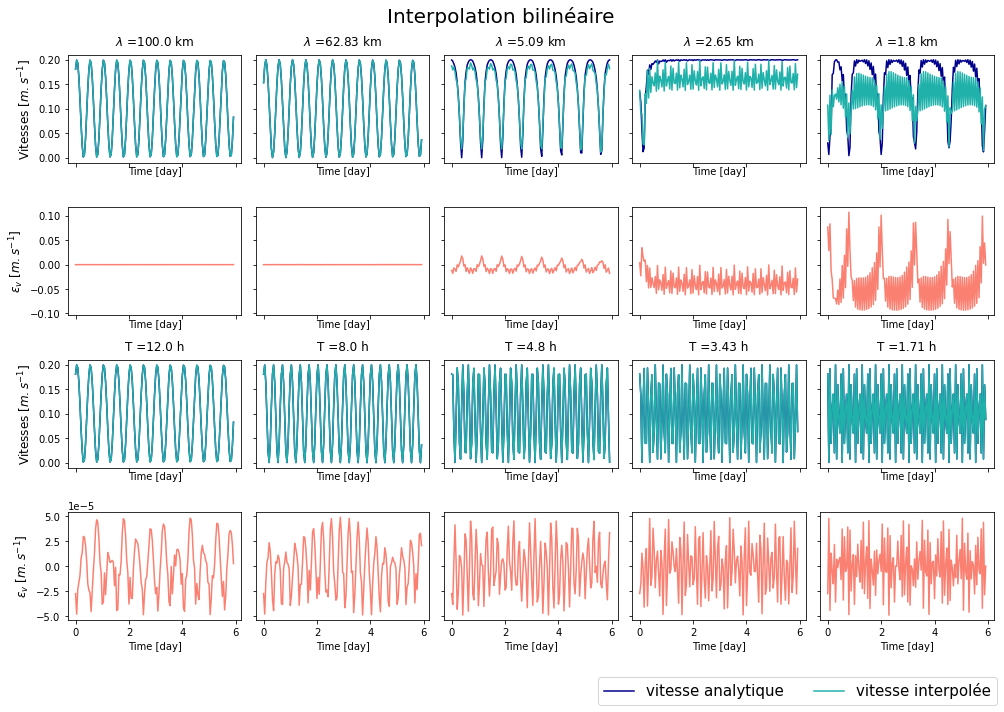

In [21]:
W=[x*sti.w2 for x in [1,1.5,2.5,3.5,7]]
Ka=[iti.k2]+list(np.linspace(0.0001,0.0035,len(W)-1))
K=[iti.k2]+list(np.linspace(0.0001,0.001,len(W)-1))
run_v(Ka,W)

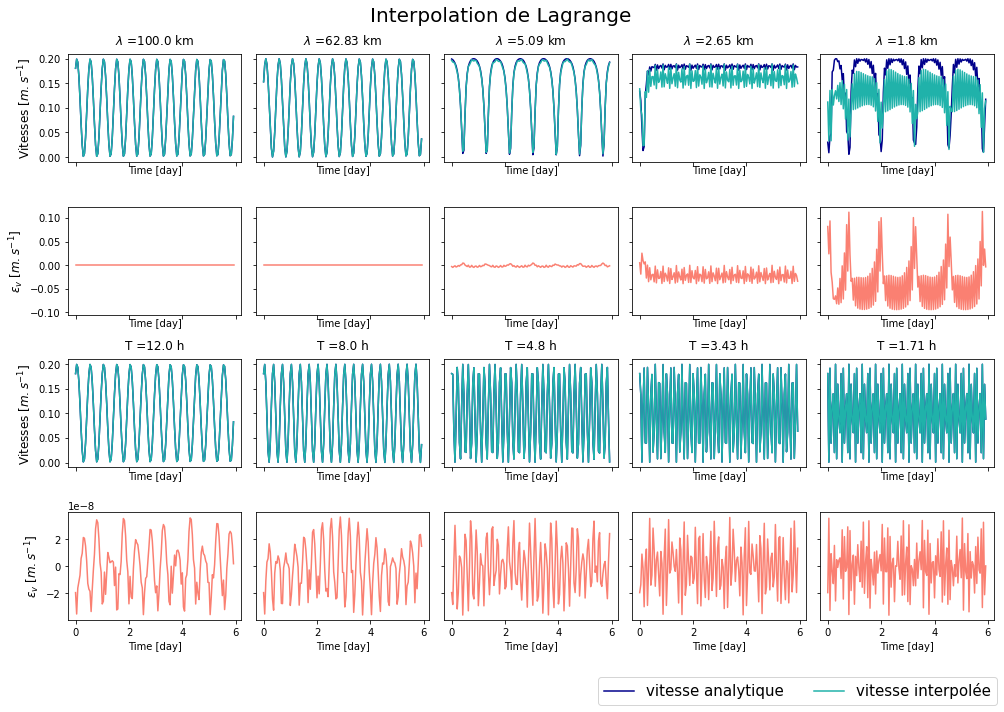

In [22]:
run_v(Ka,W, inter_method='lagrange')